# 3. Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import processing
import feature_eng

In [4]:
df = pd.read_csv("Loan_data_after_eda.csv")

In [5]:
df.shape

(39786, 29)

In [6]:
processing.print_distribution_in_percents(df, 'earliest_cr_line_year')

1946    0.00
1950    0.00
1954    0.01
1956    0.00
1959    0.00
1961    0.01
1962    0.01
1963    0.03
1964    0.02
1965    0.02
1966    0.03
1967    0.05
1968    0.05
1969    0.09
1970    0.12
1971    0.12
1972    0.13
1973    0.17
1974    0.16
1975    0.21
1976    0.24
1977    0.29
1978    0.41
1979    0.41
1980    0.45
1981    0.47
1982    0.56
1983    0.85
1984    1.04
1985    1.17
1986    1.26
1987    1.56
1988    1.86
1989    2.17
1990    2.61
1991    2.47
1992    2.68
1993    3.82
1994    5.11
1995    5.41
1996    5.72
1997    6.19
1998    7.19
1999    7.47
2000    8.17
2001    6.34
2002    4.85
2003    4.67
2004    4.43
2005    3.76
2006    2.94
2007    1.79
2008    0.40
Name: earliest_cr_line_year, dtype: float64


In [7]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'annual_inc_cat_10',
       'target', 'loan_amnt_cat_10', 'inc_ver_status', 'inc_source_ver_status',
       'fico_range_low_cat_num', 'earliest_cr_line_year',
       'earliest_cr_line_month', 'issue_d_year', 'issue_d_month', 'grade_num',
       'home_MORTGAGE', 'home_OTHER', 'home_OWN', 'home_RENT'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               39786 non-null  float64
 1   term                    39786 non-null  int64  
 2   int_rate                39786 non-null  int64  
 3   installment             39786 non-null  float64
 4   emp_length              39786 non-null  float64
 5   annual_inc              39786 non-null  float64
 6   dti                     39786 non-null  float64
 7   delinq_2yrs             39786 non-null  float64
 8   fico_range_low          39786 non-null  float64
 9   inq_last_6mths          39786 non-null  float64
 10  open_acc                39786 non-null  float64
 11  revol_bal               39786 non-null  float64
 12  revol_util              39786 non-null  float64
 13  total_acc               39786 non-null  float64
 14  annual_inc_cat_10       39786 non-null

### Outliers

Szukam wartości odstających wśród zmiennych numerycznych, wyłączając zmienne binarne, kategoryczne oraz miesiące. Najpierw jeszcze raz spojrzę na ich rozkłady na histogramach.

array([[<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'installment'}>,
        <AxesSubplot:title={'center':'emp_length'}>],
       [<AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'fico_range_low'}>],
       [<AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'open_acc'}>,
        <AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>],
       [<AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'center':'earliest_cr_line_year'}>,
        <AxesSubplot:title={'center':'issue_d_year'}>, <AxesSubplot:>]],
      dtype=object)

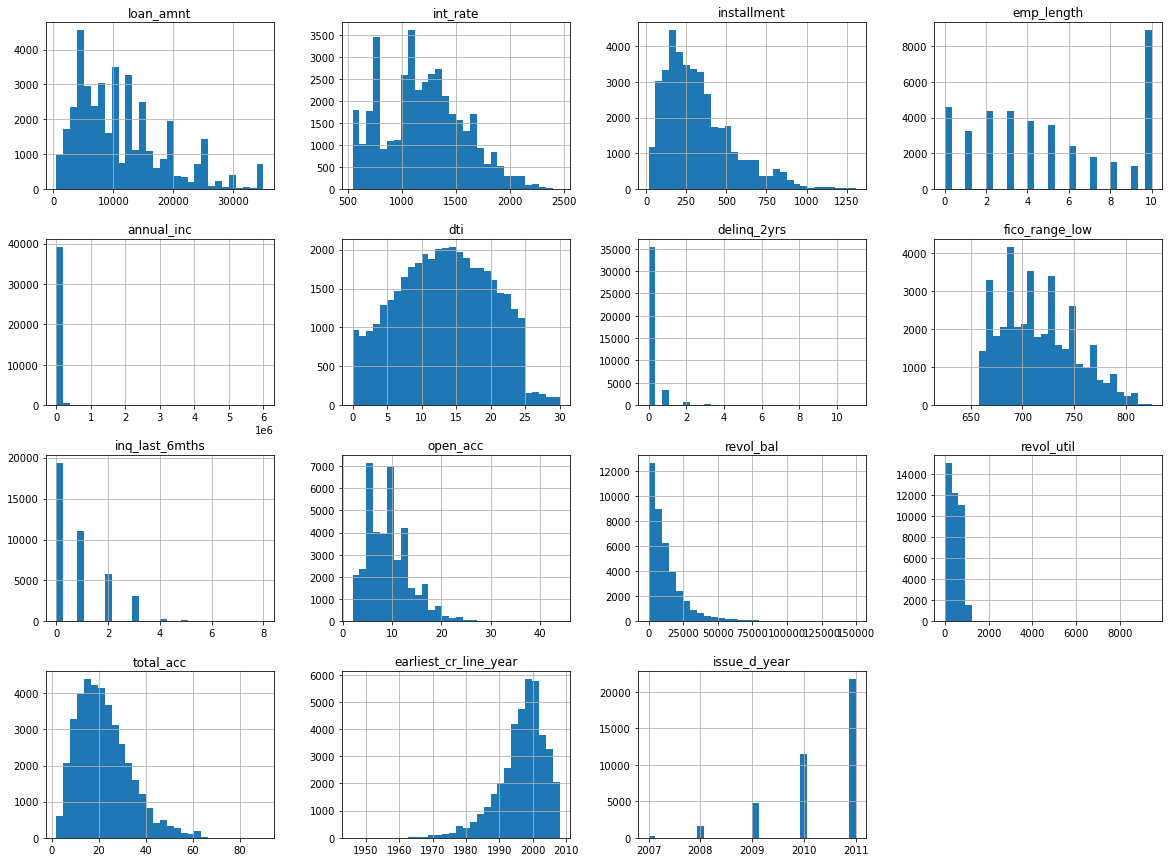

In [9]:
column_list = ['loan_amnt', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_line_year', 'issue_d_year']
df[column_list].hist(bins=30, figsize=(20, 15))

Zobaczę też, jak to wygląda na boxplotach:

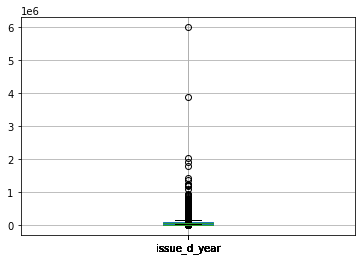

In [10]:
for column in column_list:
    df.boxplot(column=[column])
# dobra, tutaj nie wiem, jak te boxploty zrobić, zapytać na konsach TODO

Podsumowanie:

- 'emp_length' - rozkład jest nieregularny, ostatnia wartośc przeważa, dlatego, że w niej zawierają się równiez wszystkie wartości większe niż 10 - w takm razie nie należy tej zmiennej traktować jak typową zmienną numeryczną i nie będę szukać wartości odstających
- 'dti', 'fico_range_low' - rozkład ok
- 'issue_d_year' - rozkład skośny ale też niewiele wartości, przyda się zlogarytmowanie
- 'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_line_year' - rozkład jest skośny, przyda się zbadanie wartości odstających i zlogarytmowanie

In [11]:
column_list_for_outliers = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 
                        'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_line_year']

feature_eng.find_outliers_method_normal_distribution(df, column_list_for_outliers, 3)

Number of outliers in loan_amnt:  719
Number of outliers in int_rate:  38
Number of outliers in installment:  328
Number of outliers in annual_inc:  289
Number of outliers in delinq_2yrs:  1011
Number of outliers in inq_last_6mths:  260
Number of outliers in open_acc:  373
Number of outliers in revol_bal:  872
Number of outliers in revol_util:  54
Number of outliers in total_acc:  354
Number of outliers in earliest_cr_line_year:  585


Licząc metodą, według której jako obserwację odstającą można uznać obserwację, która po wystandaryzowaniu ma wartość poniżej -3 lub powyżej 3, otrzymaliśmy powyższe liczby obserwacji odstających w każdej ze zmiennych. 

Jednocześnie biorąc pod uwagę właściwości tych zmiennych zdaję sobie sprawę z tego, że raczej nie są to błędy w danych, a po prostu wartości odbiegające od typowych, które się mogą pojawić w zbiorze.

Ponieważ algorytmy mogą być wrażliwe na wartości odstające, stworzę zmienne o wartościach zlogarytmowanych, aby zminimalizować ten wpływ.

### Transformacja logarytmiczna

In [12]:
# logarytm
feature_eng.log_plus_1_transform(df, column_list_for_outliers)

array([[<AxesSubplot:title={'center':'loan_amnt_log+1'}>,
        <AxesSubplot:title={'center':'int_rate_log+1'}>,
        <AxesSubplot:title={'center':'installment_log+1'}>],
       [<AxesSubplot:title={'center':'annual_inc_log+1'}>,
        <AxesSubplot:title={'center':'delinq_2yrs_log+1'}>,
        <AxesSubplot:title={'center':'inq_last_6mths_log+1'}>],
       [<AxesSubplot:title={'center':'open_acc_log+1'}>,
        <AxesSubplot:title={'center':'revol_bal_log+1'}>,
        <AxesSubplot:title={'center':'revol_util_log+1'}>],
       [<AxesSubplot:title={'center':'total_acc_log+1'}>,
        <AxesSubplot:title={'center':'earliest_cr_line_year_log+1'}>,
        <AxesSubplot:>]], dtype=object)

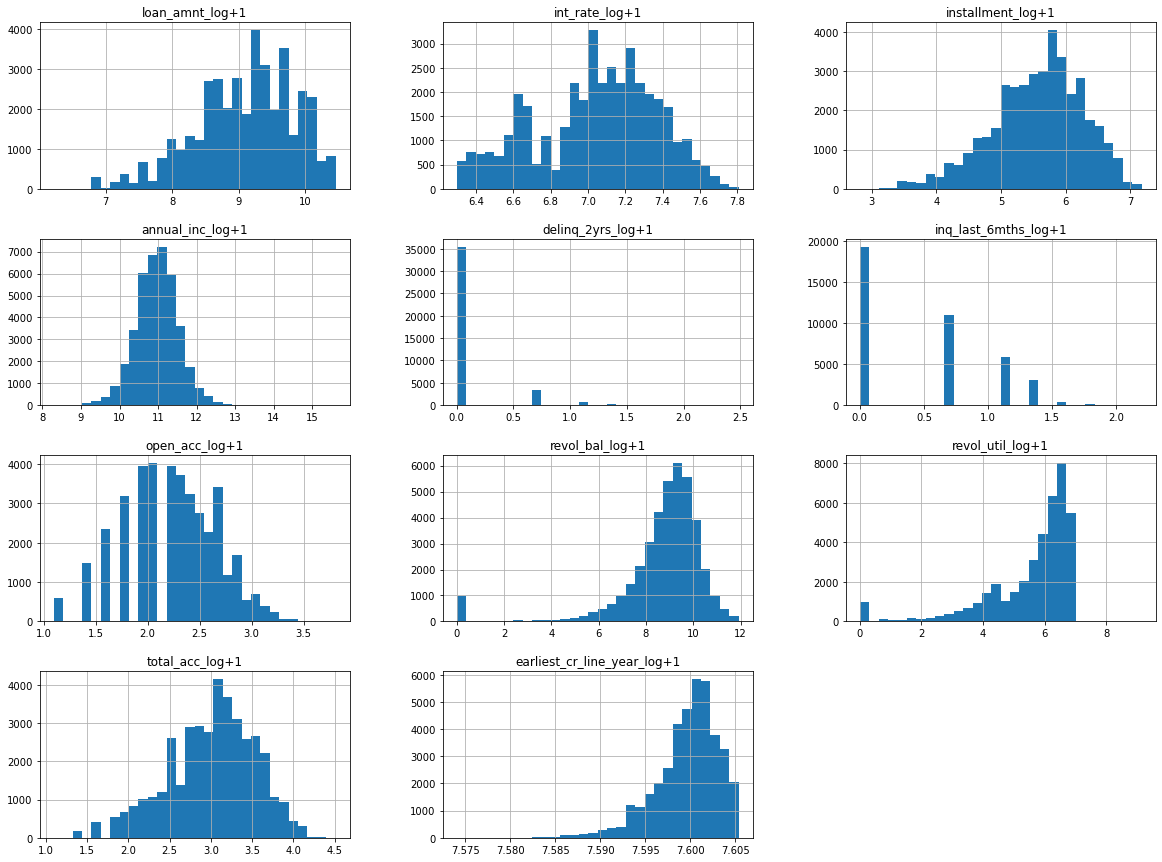

In [13]:
column_list = ['loan_amnt_log+1', 'int_rate_log+1', 'installment_log+1', 'annual_inc_log+1', 'delinq_2yrs_log+1', 
               'inq_last_6mths_log+1', 'open_acc_log+1', 'revol_bal_log+1', 'revol_util_log+1', 'total_acc_log+1', 
               'earliest_cr_line_year_log+1']
df[column_list].hist(bins=30, figsize=(20, 15))

Po zlogarytmowaniu rozkłady wyglądają dużo lepiej.

### Zmienne binarne

In [14]:
# dla zmiennej emp_length wartości poniżej 10 kwalifikuję jako 0, wartości 10 - jako 1
df['emp_length_bin'] = (df['emp_length'] == 10).astype(int)
df["emp_length_bin"].head()

0    1
1    0
2    1
3    1
4    0
Name: emp_length_bin, dtype: int32

In [15]:
# dla kilku innych zmiennych, z tym, że dla nich jako wartość graniczną przyjmuję medianę:
column_list = ['annual_inc', 'int_rate', 'installment', 'loan_amnt']
feature_eng.create_binary_variables_with_median(df, column_list)

### Inne

In [16]:
# ACC - open/total ratio
df['acc_ratio'] = df['open_acc'] / df['total_acc']

<AxesSubplot:>

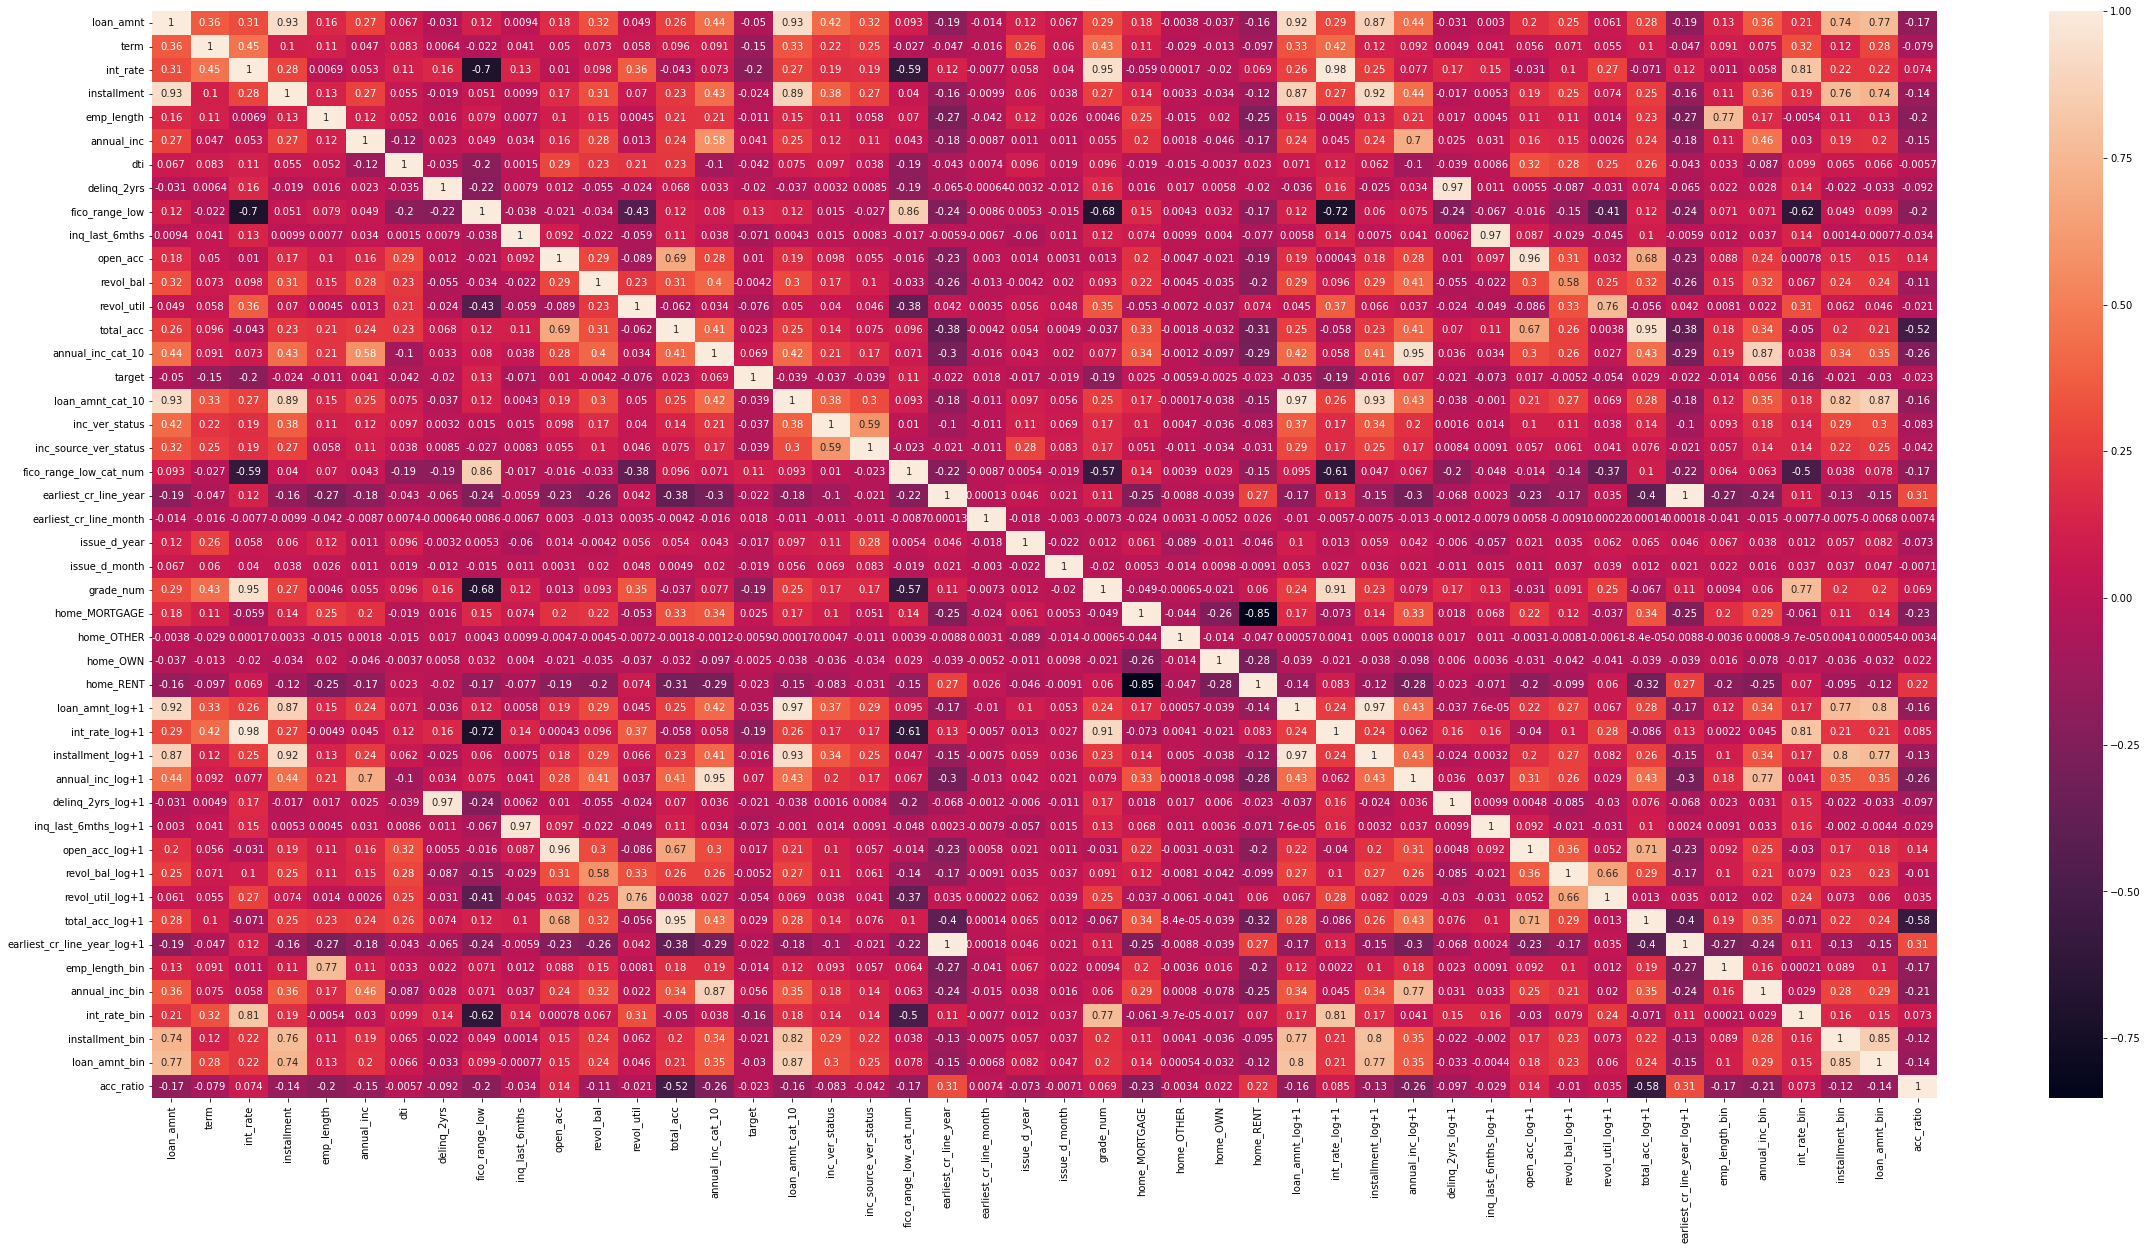

In [17]:
plt.figure(figsize = (40,20))       
sns.heatmap(df.corr(),annot = True)

In [19]:
df.to_csv('Loan_data_after_feature_eng.csv', index=False)